In [1]:
import pandas as pd
import numpy as np
import os
import gzip
from functools import reduce

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#### Accounting and modelling
The measures that we will monitor over time are: 
- Number of reviews (proxy for contracts/use) 
- Price 
- Occupancy
- Value (price * occupancy)
- Listing rating (overall score)

#### Measuring intangibles

1) Descriptive analysis of the number of contracts and their characterisation, performance and KPIs in general:  
time-series analysis of the **number of contracts** to identify potential autocorrelation 
resulting from the role held in the contract network; 

2) The impact of trust and other intangibles in host and platform performance:  
identify key features affecting the above measure, with a particular interest on **trust** (proxies by number of previous reviews and overall score)

3) Covid-mitigation activities: 
assess the impact of **covid** mitigation activities starting from listing description.

In [2]:
# link con descrizione variabili
## https://rstudio-pubs-static.s3.amazonaws.com/407929_afc5ef0f2ad648389447a6ca3f4a7cd4.html

In [3]:
data_path = '../../../ecme/UC1: Digital Platform/Data/'

In [4]:
with gzip.open(data_path + 'POLICY_NETWORK.csv.gzip') as file_in:
    df = pd.read_csv(file_in, low_memory=False)

In [5]:
df.shape

(6640646, 13)

In [6]:
df.dtypes

MODEL_INSTANCE                    object
TIME_STAMP                        object
PARTIES_PROPOSER_ID                int64
PARTIES_PARTICIPANT_ID             int64
ASSET_ID                           int64
ASSET_PRICE                       object
ASSET_MIGRATION                  float64
ASSET_LOCATION                    object
ASSETS_REVIEW_SCORES_ACCURACY    float64
ASSET_NUMBER_REVIEWS             float64
ASSET_AVAILABILITY_30            float64
YEAR                               int64
MONTH                              int64
dtype: object

In [7]:
df.isnull().sum()/len(df)

MODEL_INSTANCE                   0.00000
TIME_STAMP                       0.00000
PARTIES_PROPOSER_ID              0.00000
PARTIES_PARTICIPANT_ID           0.00000
ASSET_ID                         0.00000
ASSET_PRICE                      0.83287
ASSET_MIGRATION                  0.83287
ASSET_LOCATION                   0.83287
ASSETS_REVIEW_SCORES_ACCURACY    0.83287
ASSET_NUMBER_REVIEWS             0.83287
ASSET_AVAILABILITY_30            0.83287
YEAR                             0.00000
MONTH                            0.00000
dtype: float64

- **MODEL_INSTANCE** --> contract id
- **PARTIES_PROPOSER_ID** --> host id
- **PARTIES_PARTICIPANT_ID** --> guest id
- **ASSET_ID** --> B&B id

In [8]:
df.head()

,MODEL_INSTANCE,TIME_STAMP,PARTIES_PROPOSER_ID,PARTIES_PARTICIPANT_ID,ASSET_ID,ASSET_PRICE,ASSET_MIGRATION,ASSET_LOCATION,ASSETS_REVIEW_SCORES_ACCURACY,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,YEAR,MONTH
0,PJNs4Fpyg4,2015-04-10,62142,30537860,15883,NaN,NaN,NaN,NaN,NaN,NaN,2015,4
1,rGvohKWuaC,2016-06-19,62142,37529754,15883,$85.00,0.0,vienna,10.0,1.0,9.0,2016,6
2,O1ZE3GDKxL,2016-07-29,62142,3147341,15883,$85.00,0.0,vienna,10.0,2.0,17.0,2016,7
3,2t2vxoLsH5,2016-08-13,62142,29518067,15883,$85.00,0.0,vienna,9.0,3.0,9.0,2016,8
4,KBHJiEPuFf,2016-11-21,62142,36016357,15883,$85.00,0.0,vienna,10.0,4.0,9.0,2016,11


In [9]:
df.MODEL_INSTANCE.duplicated().sum()

0

#### Contracts/Location

In [10]:
df_location_cont = pd.pivot_table(data = df,
                                  index=['YEAR'],
                                  columns = "ASSET_LOCATION",
                                  values=["MODEL_INSTANCE"], 
                                  aggfunc="count",
                                  )

df_location_cont.columns = [col[1] for col in df_location_cont.columns]

In [11]:
df_location_cont

,amsterdam,athens,brussels,copenhagen,dublin,lisbon,madrid,prague,rome,stockholm,vienna
YEAR,,,,,,,,,,,
2015,6380.0,781.0,746.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1604.0
2016,19907.0,NaN,NaN,962.0,1770.0,NaN,NaN,NaN,NaN,NaN,16804.0
2017,30632.0,3048.0,1301.0,1429.0,691.0,NaN,NaN,NaN,12648.0,NaN,17739.0
2018,41569.0,27898.0,9410.0,5861.0,12021.0,57344.0,68985.0,27431.0,96537.0,1271.0,43247.0
2019,11532.0,60163.0,30219.0,19826.0,17216.0,106054.0,112638.0,63514.0,42350.0,NaN,34793.0
2020,3511.0,15278.0,10064.0,4359.0,222.0,10862.0,33543.0,8386.0,NaN,NaN,17305.0


In [12]:
#ASSET_PRICE
def fix_price (value):
    try:
        value = value.replace("$", '').replace(",", '')
        value = float(value)
        return value
    except: return np.nan  

df['ASSET_PRICE'] = df['ASSET_PRICE'].apply(lambda x : fix_price(x))

### PRICE AND REVIEW SCORE

In [13]:
# Every asset may have multiple PRICE AND SCORE. To compute median price and average score for location y and m, we have 
# to first group by asset and then compute grouping by location y and m once again.
      
df_price_rev = df.groupby(["ASSET_LOCATION", 'YEAR', 'MONTH', "ASSET_ID"])[["ASSET_PRICE", "ASSETS_REVIEW_SCORES_ACCURACY"]].mean().reset_index()
df_price_rev = df_price_rev.groupby(["ASSET_LOCATION", 'YEAR', 'MONTH'])\
                           .agg({"ASSET_PRICE" : "median", "ASSETS_REVIEW_SCORES_ACCURACY" : "mean"})


In [14]:
df_price_rev.head()

ASSET_PRICE  ASSETS_REVIEW_SCORES_ACCURACY
ASSET_LOCATION YEAR MONTH                                            
amsterdam      2015 8            110.0                       9.623003
                    9            110.0                       9.630849
                    10           110.0                       9.672355
                    11           100.0                       9.655172
               2016 1            109.0                       9.673469

In [15]:
df_price_rev.isnull().sum() / len(df_price_rev) * 100

ASSET_PRICE                      0.0
ASSETS_REVIEW_SCORES_ACCURACY    0.0
dtype: float64

In [16]:
# it makes no sense to use this feature with this distribution!!! (all reviews between 9 and 10)
df_price_rev[df_price_rev.ASSETS_REVIEW_SCORES_ACCURACY < 9]

,,,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY
ASSET_LOCATION,YEAR,MONTH,,


### OCCUPANCY

In [17]:
df.sort_values(by=["YEAR", "MONTH", "ASSET_ID", "TIME_STAMP"])[[
    "YEAR", "MONTH", "ASSET_ID", "TIME_STAMP",
    "PARTIES_PROPOSER_ID", "PARTIES_PARTICIPANT_ID",  "ASSET_AVAILABILITY_30"]].head(4)

,YEAR,MONTH,ASSET_ID,TIME_STAMP,PARTIES_PROPOSER_ID,PARTIES_PARTICIPANT_ID,ASSET_AVAILABILITY_30
3427923,2008,11,2903,2008-11-16,3280,3734,NaN
3427924,2008,11,2903,2008-11-28,3280,3726,NaN
3427925,2009,1,2903,2009-01-21,3280,5120,NaN
3427926,2009,2,2903,2009-02-23,3280,7671,NaN


In [18]:
df.sort_values(by=["YEAR", "MONTH", "ASSET_ID", "TIME_STAMP"])\
  .groupby(["YEAR", "MONTH", "ASSET_ID"]).tail(1)[["YEAR", "MONTH", "ASSET_ID", "TIME_STAMP",
    "PARTIES_PROPOSER_ID", "PARTIES_PARTICIPANT_ID",  "ASSET_AVAILABILITY_30"]].head(4)

,YEAR,MONTH,ASSET_ID,TIME_STAMP,PARTIES_PROPOSER_ID,PARTIES_PARTICIPANT_ID,ASSET_AVAILABILITY_30
3427924,2008,11,2903,2008-11-28,3280,3726,NaN
3427925,2009,1,2903,2009-01-21,3280,5120,NaN
3427926,2009,2,2903,2009-02-23,3280,7671,NaN
4610344,2009,3,2818,2009-03-30,3159,10952,NaN


In [19]:
# to check asset occupancy we need the last updated (time stamp) availability for every y/m & asset id
df_occupancy = df.sort_values(by=["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID", "TIME_STAMP"])\
                 .groupby(["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID"]).tail(1)

# occupancy is 30 - actual availability at the end of the month
df_occupancy['OCCUPANCY'] = 30 - df_occupancy["ASSET_AVAILABILITY_30"]

df_occupancy_gb = df_occupancy.groupby(["ASSET_LOCATION", 'YEAR', 'MONTH'])[["OCCUPANCY"]].median()

In [20]:
df_occupancy_gb.head()

OCCUPANCY
ASSET_LOCATION YEAR MONTH           
amsterdam      2015 8           28.0
                    9           27.0
                    10          25.0
                    11          21.0
               2016 1           18.0

In [21]:
df_occupancy_gb.isnull().sum()/len(df_occupancy) * 100

OCCUPANCY    0.0
dtype: float64

### MEASURES OVER TIME

In [22]:
df_gb = pd.pivot_table(data = df,
                       index=["ASSET_LOCATION", 'YEAR', 'MONTH'],
                       values=["PARTIES_PROPOSER_ID", "ASSET_ID", "MODEL_INSTANCE"], 
                       aggfunc={
                           "PARTIES_PROPOSER_ID" : "nunique", # at the same time number of contracts and reviews by definition
                           "ASSET_ID" :"nunique",
                           "MODEL_INSTANCE" : "count",
                       })[["PARTIES_PROPOSER_ID", "ASSET_ID", "MODEL_INSTANCE"]]

In [23]:
df_gb.head()

PARTIES_PROPOSER_ID  ASSET_ID  MODEL_INSTANCE
ASSET_LOCATION YEAR MONTH                                               
amsterdam      2015 8                      596       626            1807
                    9                      554       577            1696
                    10                     558       586            1698
                    11                     420       435            1179
               2016 1                      556       588            1188

#### MERGING DATA

In [24]:
df_list = [df_gb, df_price_rev, df_occupancy_gb]
df_gb = reduce(lambda left,right: pd.merge(left, right,  left_index=True, right_index=True, how='left'), df_list)

In [25]:
df_gb

PARTIES_PROPOSER_ID  ASSET_ID  MODEL_INSTANCE  \
ASSET_LOCATION YEAR MONTH                                                  
amsterdam      2015 8                      596       626            1807   
                    9                      554       577            1696   
                    10                     558       586            1698   
                    11                     420       435            1179   
               2016 1                      556       588            1188   
...                                        ...       ...             ...   
vienna         2020 2                     1142      1715            5887   
                    3                      996      1448            3010   
                    4                      129       167             221   
                    5                      184       261             427   
                    6                      422       609            1270   

                           ASSET_PRICE  ASSETS_REVIEW_SCORES_ACCURACY  \
ASSET_LOCATION YEAR MONTH                                               
amsterdam      2015 8            110.0                       9.623003   
                    9            110.0                       9.630849   
                    10           110.0                       9.672355   
                    11           100.0                       9.655172   
               2016 1            109.0                       9.673469   
...                                ...                            ...   
vienna         2020 2             62.0                       9.853061   
                    3             60.0                       9.854972   
                    4             59.0                       9.832335   
                    5             65.0                       9.831418   
                    6             65.0                       9.866995   

                           OCCUPANCY  
ASSET_LOCATION YEAR MONTH             
amsterdam      2015 8           28.0  
                    9           27.0  
                    10          25.0  
                    11          21.0  
               2016 1           18.0  
...                              ...  
vienna         2020 2           19.0  
                    3            5.0  
                    4           12.0  
                    5            8.0  
                    6           13.0  

[225 rows x 6 columns]

## COVID MITIGATION

In [26]:
# create dataframe wit sum mitigation for year and month
df_mitigation= df.sort_values(by=["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID", "TIME_STAMP"])\
                 .groupby(["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID"]).tail(1)

In [27]:

df_mitigation_gb = df_mitigation.groupby(["ASSET_LOCATION", 'YEAR', 'MONTH'])[["ASSET_MIGRATION"]].sum()

In [28]:
df_mitigation_gb

ASSET_MIGRATION
ASSET_LOCATION YEAR MONTH                 
amsterdam      2015 8                  0.0
                    9                  0.0
                    10                 0.0
                    11                 0.0
               2016 1                  0.0
...                                    ...
vienna         2020 2                  0.0
                    3                  0.0
                    4                  0.0
                    5                  0.0
                    6                  2.0

[225 rows x 1 columns]

In [29]:
### add df mitigation in df total

df_list = [df_gb, df_mitigation_gb]
df_mitigation_final = reduce(lambda left,right: pd.merge(left, right,  left_index=True, right_index=True, how='left'), df_list)

In [30]:
df_mitigation_final

PARTIES_PROPOSER_ID  ASSET_ID  MODEL_INSTANCE  \
ASSET_LOCATION YEAR MONTH                                                  
amsterdam      2015 8                      596       626            1807   
                    9                      554       577            1696   
                    10                     558       586            1698   
                    11                     420       435            1179   
               2016 1                      556       588            1188   
...                                        ...       ...             ...   
vienna         2020 2                     1142      1715            5887   
                    3                      996      1448            3010   
                    4                      129       167             221   
                    5                      184       261             427   
                    6                      422       609            1270   

                           ASSET_PRICE  ASSETS_REVIEW_SCORES_ACCURACY  \
ASSET_LOCATION YEAR MONTH                                               
amsterdam      2015 8            110.0                       9.623003   
                    9            110.0                       9.630849   
                    10           110.0                       9.672355   
                    11           100.0                       9.655172   
               2016 1            109.0                       9.673469   
...                                ...                            ...   
vienna         2020 2             62.0                       9.853061   
                    3             60.0                       9.854972   
                    4             59.0                       9.832335   
                    5             65.0                       9.831418   
                    6             65.0                       9.866995   

                           OCCUPANCY  ASSET_MIGRATION  
ASSET_LOCATION YEAR MONTH                              
amsterdam      2015 8           28.0              0.0  
                    9           27.0              0.0  
                    10          25.0              0.0  
                    11          21.0              0.0  
               2016 1           18.0              0.0  
...                              ...              ...  
vienna         2020 2           19.0              0.0  
                    3            5.0              0.0  
                    4           12.0              0.0  
                    5            8.0              0.0  
                    6           13.0              2.0  

[225 rows x 7 columns]

In [31]:
df_gb_mitigation = df_mitigation_final.reset_index()
#df_gb_flat = df_gb_flat[(df_gb_flat.YEAR >= 2016) & (df_gb_flat.YEAR < 2020)]
df_gb_mitigation['dt_index'] = pd.to_datetime(df_gb_mitigation.YEAR.astype(str) + "-" + df_gb_mitigation.MONTH.astype(str)).dt.strftime('%Y-%m')

In [32]:
df_gb_mitigation.set_index("dt_index", inplace=True)

In [33]:
df_gb_mitigation

,ASSET_LOCATION,YEAR,MONTH,PARTIES_PROPOSER_ID,ASSET_ID,MODEL_INSTANCE,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,OCCUPANCY,ASSET_MIGRATION
dt_index,,,,,,,,,,
2015-08,amsterdam,2015,8,596,626,1807,110.0,9.623003,28.0,0.0
2015-09,amsterdam,2015,9,554,577,1696,110.0,9.630849,27.0,0.0
2015-10,amsterdam,2015,10,558,586,1698,110.0,9.672355,25.0,0.0
2015-11,amsterdam,2015,11,420,435,1179,100.0,9.655172,21.0,0.0
2016-01,amsterdam,2016,1,556,588,1188,109.0,9.673469,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-02,vienna,2020,2,1142,1715,5887,62.0,9.853061,19.0,0.0
2020-03,vienna,2020,3,996,1448,3010,60.0,9.854972,5.0,0.0
2020-04,vienna,2020,4,129,167,221,59.0,9.832335,12.0,0.0


### Descriptive statistics

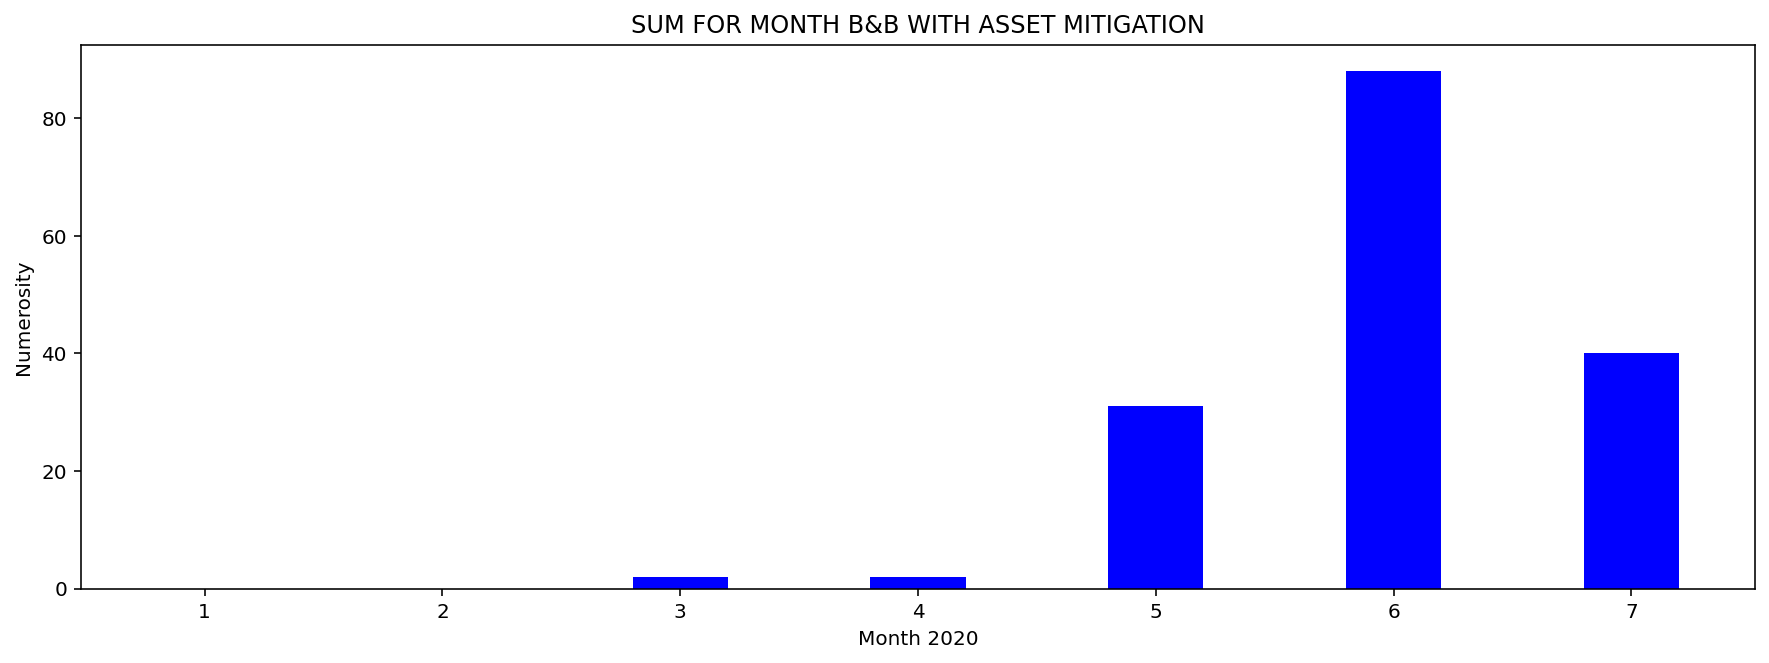

In [34]:
#### cambiamenti per mesi 2020

graph = df_gb_mitigation.reset_index()
graph = graph[(graph.YEAR > 2019)]

graph = pd.pivot_table(data = graph,
                                  index=['YEAR', "MONTH"],
                                  #columns = "ASSET_LOCATION",
                                  values=["ASSET_MIGRATION"], 
                                  aggfunc="sum",
                                  )


graph=graph.reset_index()


fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(graph.MONTH, graph.ASSET_MIGRATION, color ='blue',
        width = 0.4)
 
plt.xlabel("Month 2020")
plt.ylabel("Numerosity")
plt.title("SUM FOR MONTH B&B WITH ASSET MITIGATION")
plt.show()


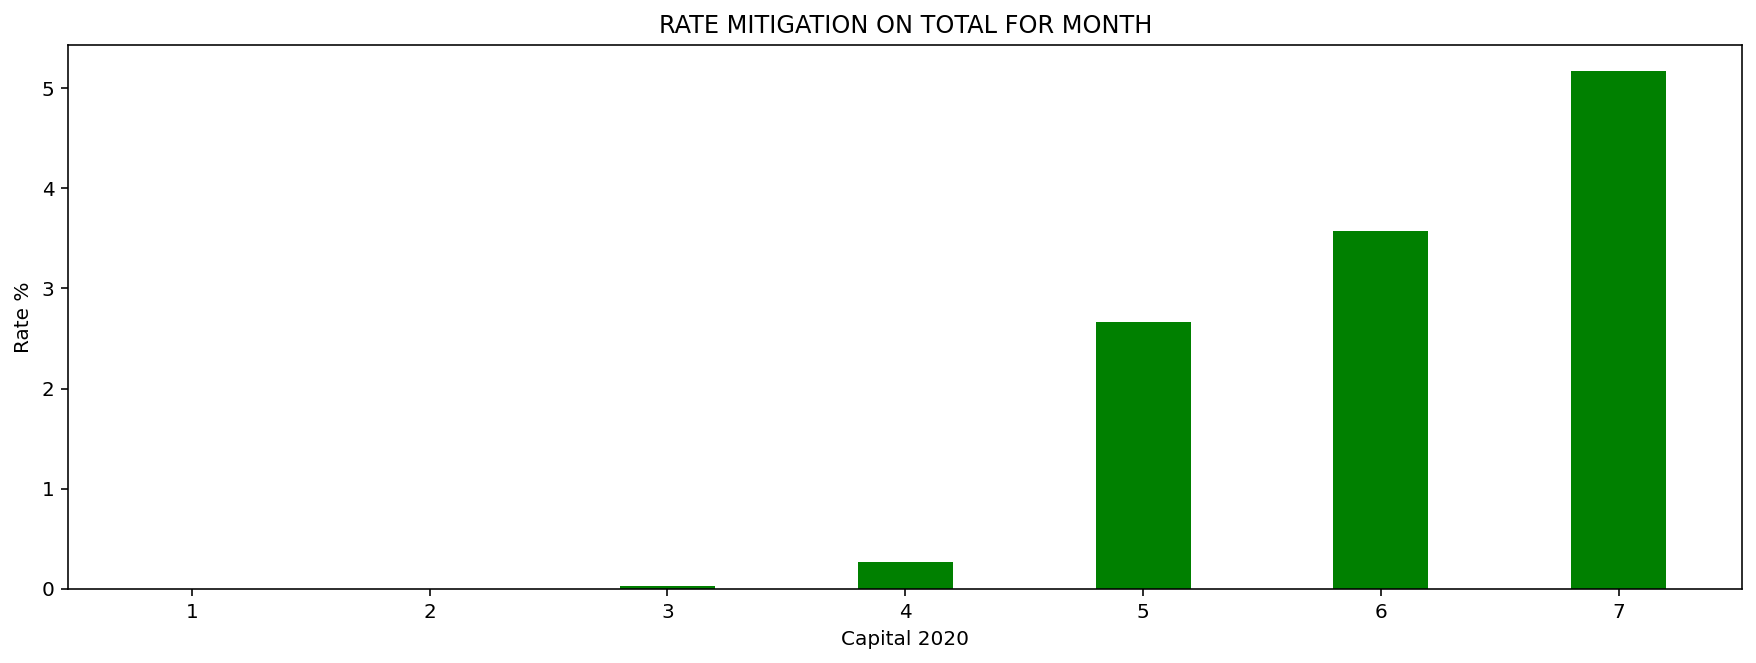

In [35]:


graph = df_gb_mitigation.reset_index()
graph = graph[(graph.YEAR > 2019)]

graph1 = pd.pivot_table(data = graph,
                                  index=['YEAR', "MONTH"],
                                    #columns = "MONTH",
                                  values=["ASSET_ID"], 
                                  aggfunc="sum",
                                  )

graph2 = pd.pivot_table(data = graph,
                                  index=['YEAR', "MONTH"],
                                 #columns = "MONTH",
                                  values=["ASSET_MIGRATION"], 
                                  aggfunc="sum",
                                  )


graph=(graph2['ASSET_MIGRATION']/graph1['ASSET_ID'])*100
graph=graph.reset_index()
graph.columns=['ASSET_YEAR','ASSET_MONTH','ASSET_MITIGATION']


fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(graph.ASSET_MONTH, graph.ASSET_MITIGATION, color ='green',
        width = 0.4)
 
plt.xlabel("Capital 2020")
plt.ylabel("Rate %")
plt.title("RATE MITIGATION ON TOTAL FOR MONTH")
plt.show()

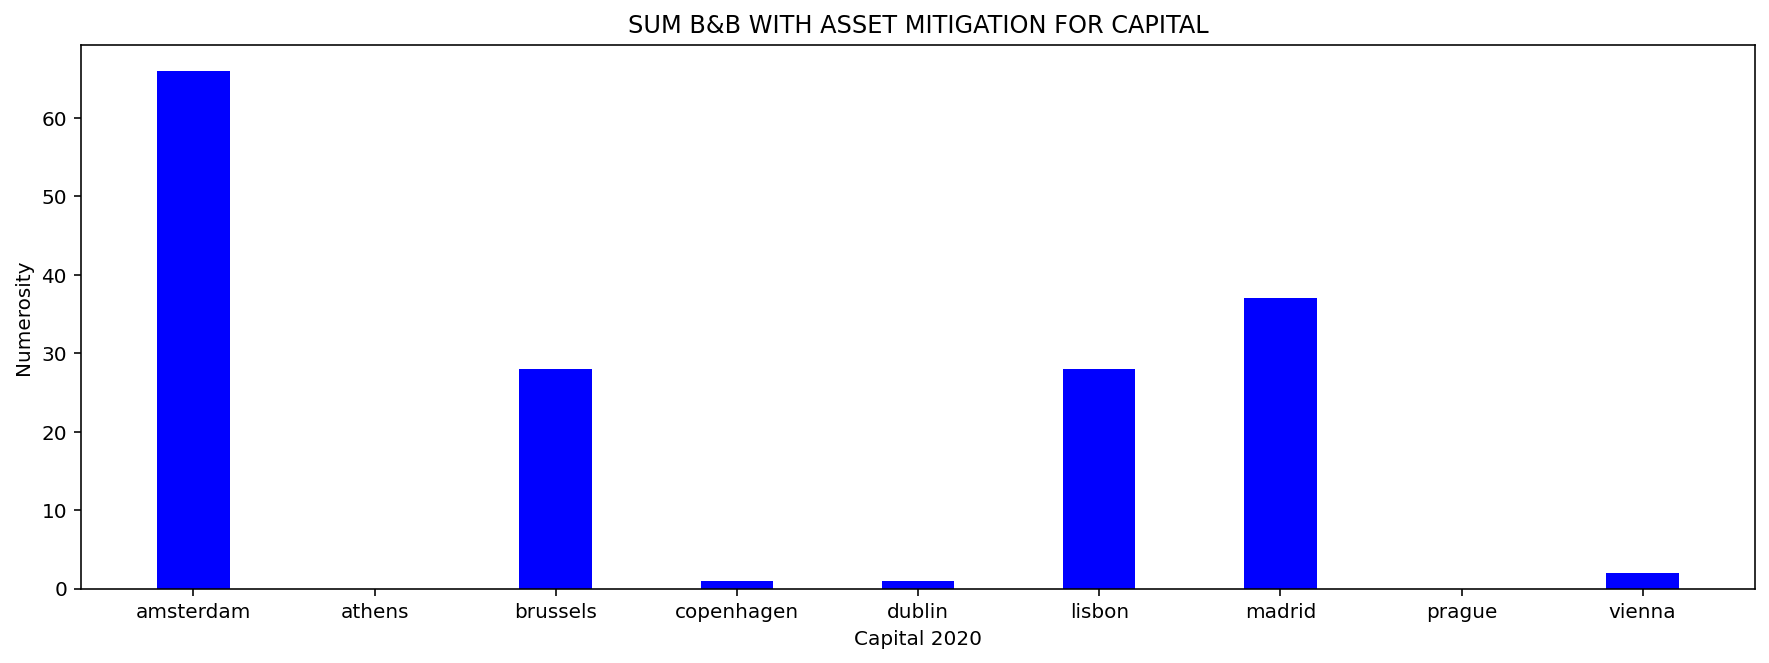

In [36]:
#### cambiamenti per capialte 2020

graph = df_gb_mitigation.reset_index()
graph = graph[(graph.YEAR > 2019)]

graph = pd.pivot_table(data = graph,
                                  index="ASSET_LOCATION",
                                  #columns = "ASSET_LOCATION",
                                  values=["ASSET_MIGRATION"], 
                                  aggfunc="sum",
                                  )


graph


graph=graph.reset_index()


fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(graph.ASSET_LOCATION, graph.ASSET_MIGRATION, color ='blue',
        width = 0.4)
 
plt.xlabel("Capital 2020")
plt.ylabel("Numerosity")
plt.title("SUM B&B WITH ASSET MITIGATION FOR CAPITAL")
plt.show()

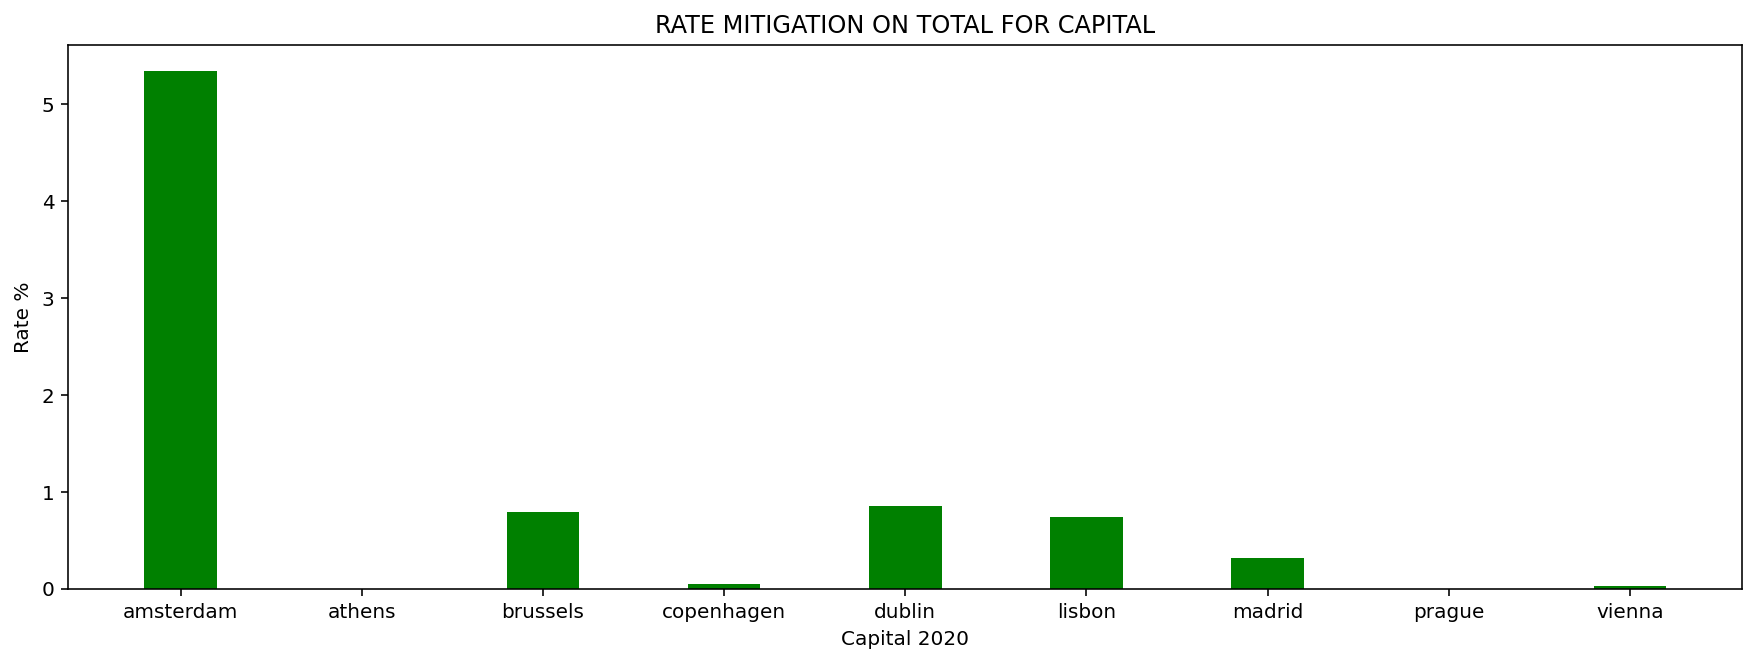

In [37]:
#### tasso cambiamenti per capialte 2020

graph = df_gb_mitigation.reset_index()
graph = graph[(graph.YEAR > 2019)]

graph1 = pd.pivot_table(data = graph,
                                  index="ASSET_LOCATION",
                                    #columns = "MONTH",
                                  values=["ASSET_ID"], 
                                  aggfunc="sum",
                                  )

graph2 = pd.pivot_table(data = graph,
                                  index="ASSET_LOCATION",
                                 #columns = "MONTH",
                                  values=["ASSET_MIGRATION"], 
                                  aggfunc="sum",
                                  )


graph=(graph2['ASSET_MIGRATION']/graph1['ASSET_ID'])*100
graph=graph.reset_index()
graph.columns=['ASSET_LOCATION','ASSET_MITIGATION']


fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(graph.ASSET_LOCATION, graph.ASSET_MITIGATION, color ='green',
        width = 0.4)
 
plt.xlabel("Capital 2020")
plt.ylabel("Rate %")
plt.title("RATE MITIGATION ON TOTAL FOR CAPITAL")
plt.show()

# ANALYSIS CORRELATION BETWEEN OCCUPANCY E MITIGATION

### FOCUS AMSTERDAM

In [38]:
df_gb_flat_corr=df_gb_mitigation[df_gb_mitigation.ASSET_LOCATION == "amsterdam"]



In [39]:
df_gb_flat_corr = df_gb_flat_corr.reset_index()
df_gb_flat_corr = df_gb_flat_corr[(df_gb_flat_corr.YEAR > 2019) & (df_gb_flat_corr.MONTH > 4)]


In [40]:
df_gb_flat_corr.ASSET_MIGRATION = df_gb_flat_corr.ASSET_MIGRATION.interpolate()
df_gb_flat_corr.OCCUPANCY = df_gb_flat_corr.OCCUPANCY.interpolate()

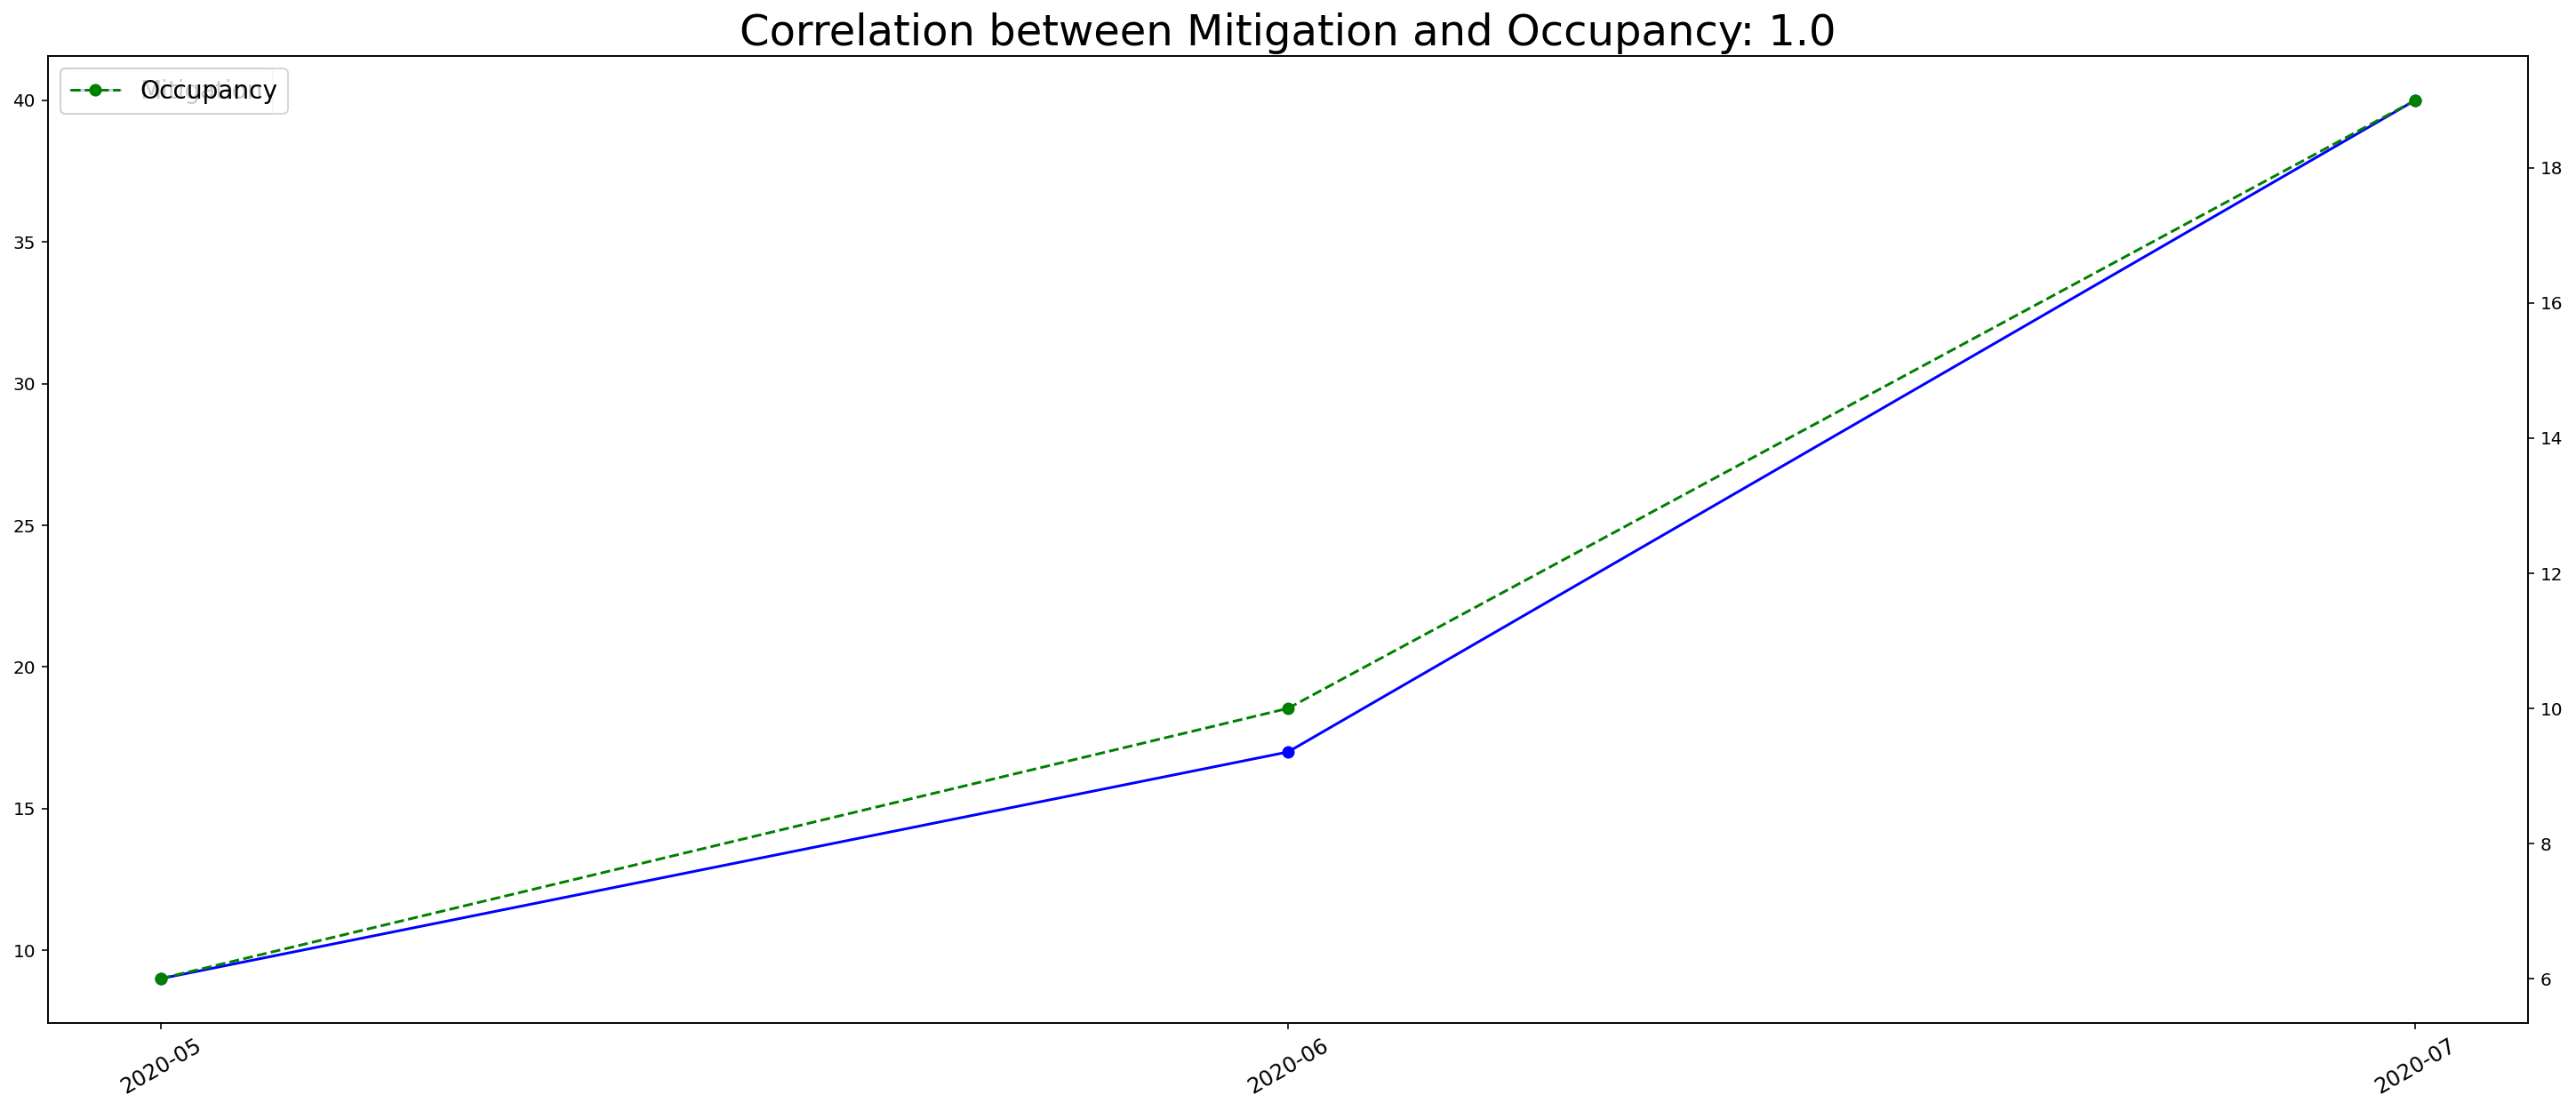

In [41]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(25, 10))
corr = round(df_gb_flat_corr.ASSET_MIGRATION.corr(df_gb_flat_corr.OCCUPANCY), 2)
plt.title('Correlation between Mitigation and Occupancy: {}'.format(corr), fontsize=24)

ax.plot(df_gb_flat_corr.dt_index, df_gb_flat_corr.ASSET_MIGRATION,
        color="blue", marker='o', label='Mitigation')
plt.xticks(df_gb_flat_corr.dt_index, fontsize=12, rotation= 30)
ax.legend(loc=2, fontsize=14)

# set x-axis label
#ax.set_xlabel("Year",fontsize=14)
# set y-axis label
#ax.set_ylabel("PARTIES_PROPOSER_ID", color="blue", fontsize=16)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df_gb_flat_corr.dt_index, df_gb_flat_corr.OCCUPANCY, color="green", ls='--', marker='o', label='Occupancy')
#ax2.set_ylabel("MODEL_INSTANCE",color="green",fontsize=16)

ax2.legend(loc=0, fontsize=14)
plt.show()

In [42]:
df_gb_flat_corr

,dt_index,ASSET_LOCATION,YEAR,MONTH,PARTIES_PROPOSER_ID,ASSET_ID,MODEL_INSTANCE,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,OCCUPANCY,ASSET_MIGRATION
35,2020-05,amsterdam,2020,5,104,114,233,135.0,9.736842,6.0,9.0
36,2020-06,amsterdam,2020,6,292,348,897,121.0,9.770115,10.0,17.0
37,2020-07,amsterdam,2020,7,661,773,2381,125.0,9.799483,19.0,40.0


### FOCUS BRUSSELS

In [43]:
df_gb_flat_corr=df_gb_mitigation[df_gb_mitigation.ASSET_LOCATION == "brussels"]
df_gb_flat_corr = df_gb_flat_corr.reset_index()

df_gb_flat_corr = df_gb_flat_corr[(df_gb_flat_corr.YEAR > 2019) & (df_gb_flat_corr.MONTH > 3)]

In [44]:
df_gb_flat_corr.ASSET_MIGRATION = df_gb_flat_corr.ASSET_MIGRATION.interpolate()
df_gb_flat_corr.OCCUPANCY = df_gb_flat_corr.OCCUPANCY.interpolate()

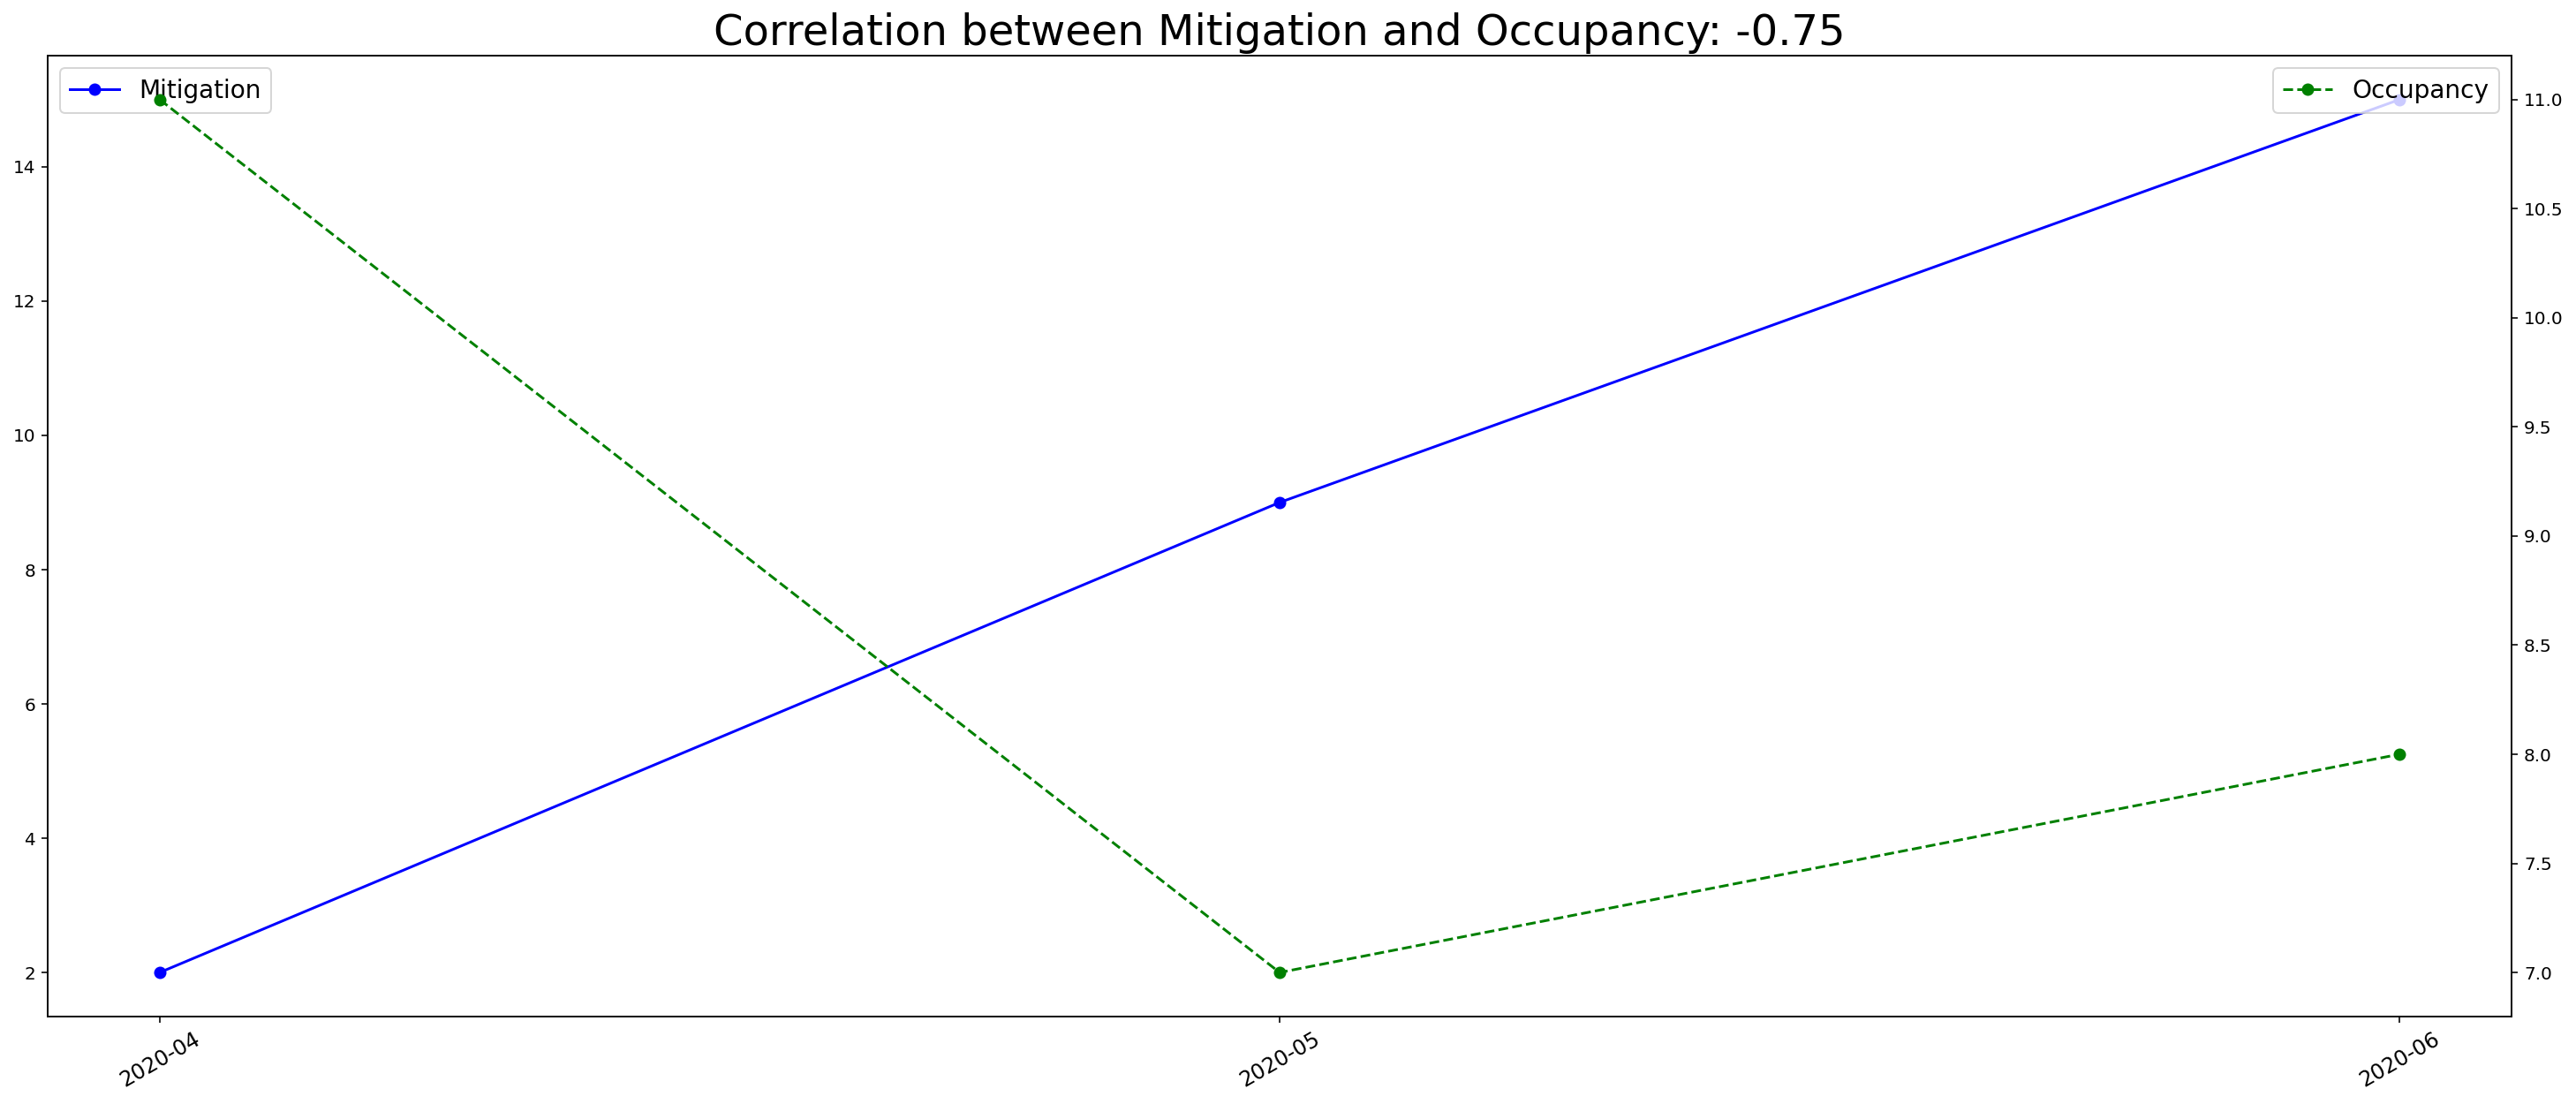

In [45]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(25, 10))
corr = round(df_gb_flat_corr.ASSET_MIGRATION.corr(df_gb_flat_corr.OCCUPANCY), 2)
plt.title('Correlation between Mitigation and Occupancy: {}'.format(corr), fontsize=24)

ax.plot(df_gb_flat_corr.dt_index, df_gb_flat_corr.ASSET_MIGRATION,
        color="blue", marker='o', label='Mitigation')
plt.xticks(df_gb_flat_corr.dt_index, fontsize=12, rotation= 30)
ax.legend(loc=2, fontsize=14)

# set x-axis label
#ax.set_xlabel("Year",fontsize=14)
# set y-axis label
#ax.set_ylabel("PARTIES_PROPOSER_ID", color="blue", fontsize=16)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df_gb_flat_corr.dt_index, df_gb_flat_corr.OCCUPANCY, color="green", ls='--', marker='o', label='Occupancy')
#ax2.set_ylabel("MODEL_INSTANCE",color="green",fontsize=16)

ax2.legend(loc=0, fontsize=14)
plt.show()

In [46]:
df_gb_flat_corr

,dt_index,ASSET_LOCATION,YEAR,MONTH,PARTIES_PROPOSER_ID,ASSET_ID,MODEL_INSTANCE,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,OCCUPANCY,ASSET_MIGRATION
18,2020-04,brussels,2020,4,95,118,153,59.5,9.745763,11.0,2.0
19,2020-05,brussels,2020,5,104,137,245,65.0,9.766423,7.0,9.0
20,2020-06,brussels,2020,6,254,334,738,65.0,9.703593,8.0,15.0


### FOCUS PRAGUE

In [47]:
df_gb_flat_corr=df_gb_mitigation[df_gb_flat.ASSET_LOCATION == "prague"]
df_gb_flat_corr = df_gb_flat_corr.reset_index()

df_gb_flat_corr = df_gb_flat_corr[(df_gb_flat_corr.YEAR > 2019) & (df_gb_flat_corr.MONTH > 3)]

NameError: name 'df_gb_flat' is not defined

In [ ]:
df_gb_flat_corr.ASSET_MIGRATION = df_gb_flat_corr.ASSET_MIGRATION.interpolate()
df_gb_flat_corr.OCCUPANCY = df_gb_flat_corr.OCCUPANCY.interpolate()

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(25, 10))
corr = round(df_gb_flat_corr.ASSET_MIGRATION.corr(df_gb_flat_corr.OCCUPANCY), 2)
plt.title('Correlation between Mitigation and Occupancy: {}'.format(corr), fontsize=24)

ax.plot(df_gb_flat_corr.dt_index, df_gb_flat_corr.ASSET_MIGRATION,
        color="blue", marker='o', label='Mitigation')
plt.xticks(df_gb_flat_corr.dt_index, fontsize=12, rotation= 30)
ax.legend(loc=2, fontsize=14)

# set x-axis label
#ax.set_xlabel("Year",fontsize=14)
# set y-axis label
#ax.set_ylabel("PARTIES_PROPOSER_ID", color="blue", fontsize=16)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df_gb_flat_corr.dt_index, df_gb_flat_corr.OCCUPANCY, color="green", ls='--', marker='o', label='Occupancy')
#ax2.set_ylabel("MODEL_INSTANCE",color="green",fontsize=16)

ax2.legend(loc=0, fontsize=14)
plt.show()

In [ ]:
df_gb_flat_corr

## Comparison occupancy between together with mitigation and together without mitigation

In [ ]:
### create df mitigation e no mitigation

df_mitigation_yes=df[df['ASSET_MIGRATION']==1]
df_mitigation_no=df[df['ASSET_MIGRATION']==0]

In [ ]:
df_mitigation_yes['freq']=1
df_mitigation_no['freq']=1

In [ ]:
df_mitigation_no

In [ ]:

# to check asset occupancy we need the last updated (time stamp) availability for every y/m & asset id
df_occupancy = df_mitigation_yes.sort_values(by=["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID", "TIME_STAMP"])\
                 .groupby(["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID"]).tail(1)

# occupancy is 30 - actual availability at the end of the month
df_occupancy['OCCUPANCY'] = 30 - df_occupancy["ASSET_AVAILABILITY_30"]

df_occupancy_yes = df_occupancy.groupby(["ASSET_LOCATION", 'YEAR', 'MONTH'])[["OCCUPANCY"]].median()


df_occupancy_yes=df_occupancy_yes.reset_index()

In [ ]:
# to check asset occupancy we need the last updated (time stamp) availability for every y/m & asset id
df_occupancy = df_mitigation_no[df_mitigation_no['TIME_STAMP'] > "2019-12-31"].sort_values(by=["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID", "TIME_STAMP"])\
                 .groupby(["ASSET_LOCATION", "YEAR", "MONTH", "ASSET_ID"]).tail(1)

# occupancy is 30 - actual availability at the end of the month
df_occupancy['OCCUPANCY'] = 30 - df_occupancy["ASSET_AVAILABILITY_30"]

df_occupancy_no = df_occupancy.groupby(["ASSET_LOCATION", 'YEAR', 'MONTH'])[["OCCUPANCY"]].median()


df_occupancy_no=df_occupancy_no.reset_index()

In [ ]:
df_yes=df_occupancy_yes[df_occupancy_yes['ASSET_LOCATION']=="amsterdam"]
df_no=df_occupancy_no[df_occupancy_no['ASSET_LOCATION']=="amsterdam"]

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(25, 10))

plt.title('Difference Occupancy Amsterdam 2020'.format(corr), fontsize=24)

ax.plot(df_yes.MONTH, df_yes.OCCUPANCY,
        color="blue", marker='o', label='Mitigation yes')
plt.xticks(df_yes.MONTH, fontsize=12, rotation= 30)
ax.plot(df_no.MONTH, df_no.OCCUPANCY, color="green", ls='--', marker='o', label='Mitigation no')
ax.legend(loc=2, fontsize=14)

# set x-axis label
#ax.set_xlabel("Year",fontsize=14)
# set y-axis label
#ax.set_ylabel("PARTIES_PROPOSER_ID", color="blue", fontsize=16)



# make a plot with different y-axis using second axis object

#ax2.set_ylabel("MODEL_INSTANCE",color="green",fontsize=16)

plt.show()

In [ ]:
df_yes=df_occupancy_yes[df_occupancy_yes['ASSET_LOCATION']=="brussels"]
df_no=df_occupancy_no[df_occupancy_no['ASSET_LOCATION']=="brussels"]

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(25, 10))

plt.title('Difference Occupany Brussels 2020'.format(corr), fontsize=24)

ax.plot(df_yes.MONTH, df_yes.OCCUPANCY,
        color="blue", marker='o', label='Mitigation yes')
plt.xticks(df_yes.MONTH, fontsize=12, rotation= 30)
ax.plot(df_no.MONTH, df_no.OCCUPANCY, color="green", ls='--', marker='o', label='Mitigation no')
ax.legend(loc=2, fontsize=14)

# set x-axis label
#ax.set_xlabel("Year",fontsize=14)
# set y-axis label
#ax.set_ylabel("PARTIES_PROPOSER_ID", color="blue", fontsize=16)



# make a plot with different y-axis using second axis object

#ax2.set_ylabel("MODEL_INSTANCE",color="green",fontsize=16)

plt.show()

In [ ]:
df_yes=df_occupancy_yes[df_occupancy_yes['ASSET_LOCATION']=="prague"]
df_no=df_occupancy_no[df_occupancy_no['ASSET_LOCATION']=="prague"]

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(25, 10))

plt.title('Difference Occupany Prague 2020'.format(corr), fontsize=24)

ax.plot(df_yes.MONTH, df_yes.OCCUPANCY,
        color="blue", marker='o', label='Mitigation yes')
plt.xticks(df_yes.MONTH, fontsize=12, rotation= 30)
ax.plot(df_no.MONTH, df_no.OCCUPANCY, color="green", ls='--', marker='o', label='Mitigation no')
ax.legend(loc=2, fontsize=14)

# set x-axis label
#ax.set_xlabel("Year",fontsize=14)
# set y-axis label
#ax.set_ylabel("PARTIES_PROPOSER_ID", color="blue", fontsize=16)



# make a plot with different y-axis using second axis object

#ax2.set_ylabel("MODEL_INSTANCE",color="green",fontsize=16)

plt.show()